In [1]:
!pip install pennylane pennylane-qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.9/249.9 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

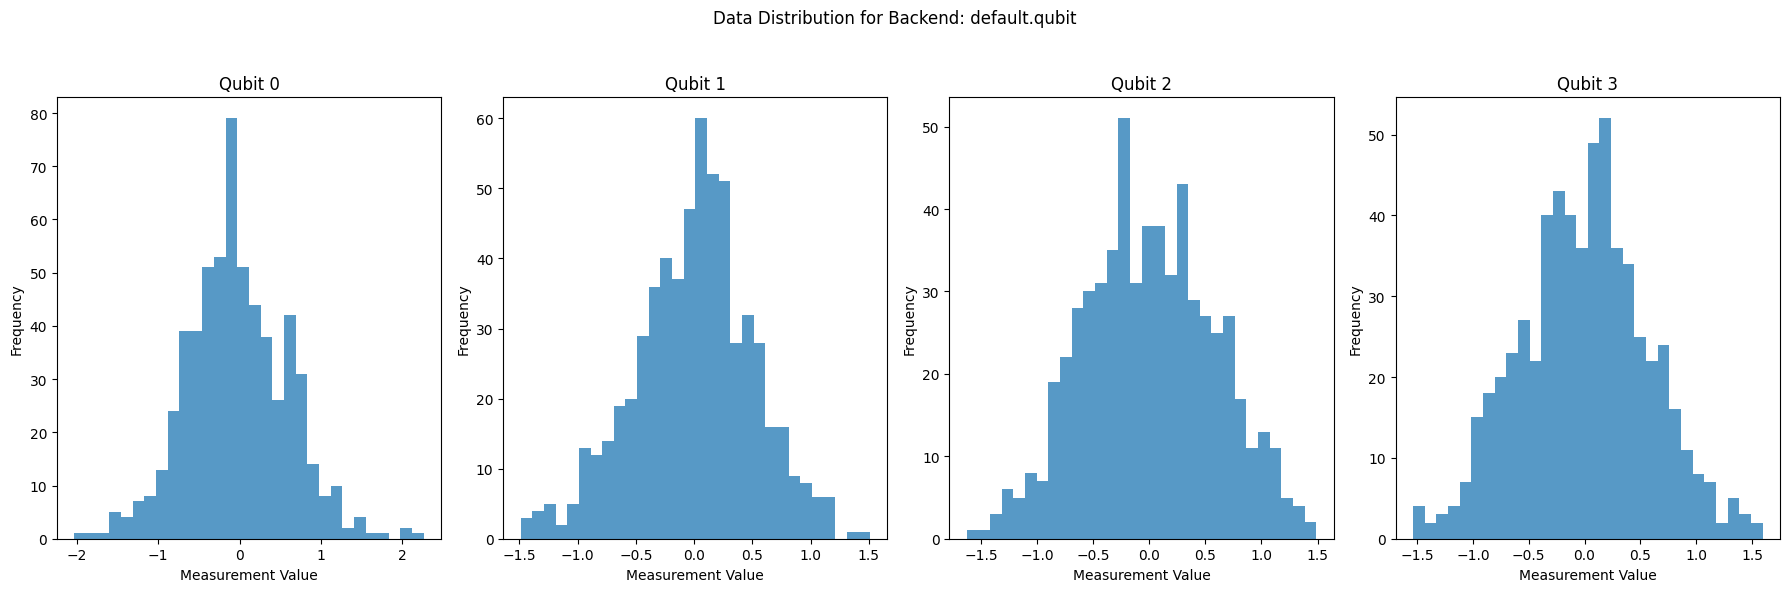

Discriminator Step 0: cost = 0.08528138524749018


Discriminator Step 5: cost = 0.02227190741508167


Discriminator Step 10: cost = 0.005608673531399155


Discriminator Step 15: cost = -0.002312449697069563


Discriminator Step 20: cost = -0.011850620846677151


Discriminator Step 25: cost = -0.03529348570935448


Discriminator Step 30: cost = -0.11299831304611269


Discriminator Step 35: cost = -0.3088204884418858


Discriminator Step 40: cost = -0.4510904234714057


Discriminator Step 45: cost = -0.4821256884251732


Generator Step 0: cost = -0.5867283523744266


Generator Step 5: cost = -0.9058053637247347


Generator Step 10: cost = -0.977718152651514


Generator Step 15: cost = -0.992727865212218


Generator Step 20: cost = -0.9971790956553314


Generator Step 25: cost = -0.9986999648536734


Generator Step 30: cost = -0.9992429096619511


Generator Step 35: cost = -0.999439703836632


Generator Step 40: cost = -0.9995114469873569


Generator Step 45: cost = -0.9995376633420158


Prob(real classified as real): 0.9818716057055548
Prob(fake classified as real): 0.9995460205985041
Discriminator cost: 0.017674414892949297
Real Bloch vector: [tensor(-0.21694187, requires_grad=True), tensor(0.45048443, requires_grad=True), tensor(-0.8660254, requires_grad=True)]
Generator Bloch vector: [<tf.Tensor: shape=(), dtype=float64, numpy=-0.3308767881435189>, <tf.Tensor: shape=(), dtype=float64, numpy=0.21647158101885466>, <tf.Tensor: shape=(), dtype=float64, numpy=-0.9184989127981876>]
Accuracy of the classifier on generated data: 0.45
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.46      0.50        24
           1       0.35      0.44      0.39        16

    accuracy                           0.45        40
   macro avg       0.45      0.45      0.44        40
weighted avg       0.47      0.45      0.46        40



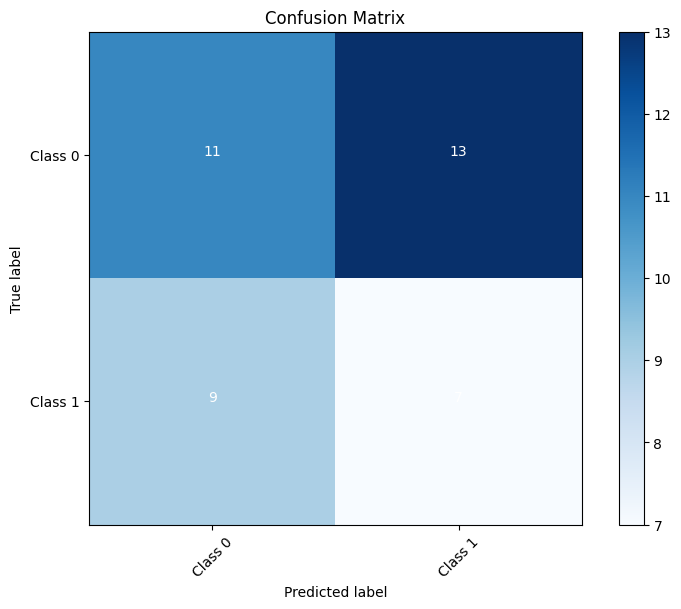

In [5]:
import numpy as np
import pennylane as qml
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools
from scipy.stats import unitary_group
import pywt

# Set the seed for reproducibility
np.random.seed(42)

# Setup Quantum Backends and Parameters
qubits = 4
depth = 2
num_samples = 200
noise_strength = 0.5
backend_names = ['default.qubit', 'qiskit.aer', 'qiskit.ibmq']

def haar_transform(data):
    coeffs = pywt.dwt2(data, 'haar')
    return coeffs

# Inverse Haar Transform
def inverse_haar_transform(coeffs):
    return idwt2(coeffs, 'haar')

# Define Quantum Volume Circuit with Noise
def quantum_volume_circuit_with_noise(qubits, depth, noise_strength=0.5, seed=None):
    dev = qml.device("default.qubit", wires=qubits)

    @qml.qnode(dev)
    def circuit(data):
        np.random.seed(seed)
        # Apply Haar transformation
        data = haar_transform(data)

        # Apply Haar-random unitaries
        for wire in range(qubits):
            haar_unitary = unitary_group.rvs(2)
            qml.QubitUnitary(haar_unitary, wires=wire)

        # Interleave random two-qubit gates
        for _ in range(depth):
            qml.broadcast(qml.CNOT, wires=range(qubits), pattern='ring')
            qml.broadcast(qml.CY, wires=range(qubits), pattern='ring')
            qml.broadcast(qml.CZ, wires=range(qubits), pattern='ring')

        # Measure Pauli observables
        measurements = [qml.expval(qml.PauliX(wire)) for wire in range(qubits)]
        measurements += [qml.expval(qml.PauliY(wire)) for wire in range(qubits)]
        measurements += [qml.expval(qml.PauliZ(wire)) for wire in range(qubits)]

        return measurements

    return circuit

# Generate Synthetic Data
circuits = []
for backend_name in backend_names:
    dev = qml.device('default.qubit', wires=qubits)
    circuit = quantum_volume_circuit_with_noise(qubits, depth, noise_strength)
    circuits.append((dev, circuit))

data = {backend_name: [] for backend_name in backend_names}
for backend, circuit in circuits:
    for _ in range(num_samples):
        # Generate random data
        random_data = np.random.rand(qubits * 3).reshape((3, qubits))
        result = np.array(circuit(random_data))
        noisy_result = result + np.random.normal(scale=noise_strength, size=result.shape)
        data[backend.name].append(noisy_result)

# Visualize Data Distributions
for backend_name in backend_names:
    backend_data = np.array(data[backend_name])
    if len(backend_data) > 0:
        plt.figure(figsize=(18, 6))
        plt.suptitle(f"Data Distribution for Backend: {backend_name}")
        for i, qubit in enumerate(range(qubits)):
            plt.subplot(1, qubits, i + 1)
            plt.hist(backend_data[:, i], bins=30, alpha=0.75)
            plt.xlabel("Measurement Value")
            plt.ylabel("Frequency")
            plt.title(f"Qubit {qubit}")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Real Data Circuit
def real(angles, **kwargs):
    qml.Hadamard(wires=0)
    qml.Rot(*angles, wires=0)

# Generator Circuit
def generator(w, **kwargs):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)

# Discriminator Circuit
def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)

# QNodes
dev = qml.device("default.qubit", wires=4)  # Define the device used in the QNodes

@qml.qnode(dev)
def real_disc_circuit(phi, theta, omega, disc_weights):
    real([phi, theta, omega])
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

@qml.qnode(dev)
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

# QGAN Cost Functions
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(phi, theta, omega, disc_weights)
    return (true_disc_output + 1) / 2

def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    return (fake_disc_output + 1) / 2

def disc_cost(disc_weights):
    return prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)

def gen_cost(gen_weights):
    return -prob_fake_true(gen_weights, disc_weights)

# Training QGAN
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 8) + np.random.normal(scale=eps, size=(9,))
init_disc_weights = np.random.normal(size=(9,))

gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

opt = tf.keras.optimizers.SGD(0.4)
opt.build([disc_weights, gen_weights])
# Train Discriminator
cost = lambda: disc_cost(disc_weights)
for step in range(50):
    opt.minimize(cost, [disc_weights])
    if step % 5 == 0:
        print(f"Discriminator Step {step}: cost = {cost().numpy()}")

# Train Generator
cost = lambda: gen_cost(gen_weights)
for step in range(50):
    opt.minimize(cost, [gen_weights])
    if step % 5 == 0:
        print(f"Generator Step {step}: cost = {cost().numpy()}")

print(f"Prob(real classified as real): {prob_real_true(disc_weights).numpy()}")
print(f"Prob(fake classified as real): {prob_fake_true(gen_weights, disc_weights).numpy()}")
print(f"Discriminator cost: {disc_cost(disc_weights).numpy()}")

# Compare Real and Generator States
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]

@qml.qnode(dev)
def bloch_vector_real(angles):
    real(angles)
    return [qml.expval(o) for o in obs]

@qml.qnode(dev)
def bloch_vector_generator(angles):
    generator(angles)
    return [qml.expval(o) for o in obs]

print(f"Real Bloch vector: {bloch_vector_real([phi, theta, omega])}")
print(f"Generator Bloch vector: {bloch_vector_generator(gen_weights)}")

def visualize_classifier_performance(y_true, y_pred, num_classes):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(num_classes)], output_dict=True)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, [f"Class {i}" for i in range(num_classes)], rotation=45)
    plt.yticks(tick_marks, [f"Class {i}" for i in range(num_classes)])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    plt.show()

# Define the number of generated samples
num_generated_samples = 200

# Define the number of features and classes
num_features = qubits * 3  # As we have 3 Pauli observables per qubit
num_classes = 2  # Example: Binary classification

# Generate synthetic labels for the generated data
y_generated = np.random.randint(0, num_classes, size=num_generated_samples)

# Generate synthetic data
X_generated = np.random.rand(num_generated_samples, num_features)

# Split the synthetic data and labels into training and testing sets
X_generated_train, X_generated_test, y_generated_train, y_generated_test = train_test_split(X_generated, y_generated, test_size=0.2, random_state=42)

# Train a classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_generated_train, y_generated_train)

# Evaluate the classifier
y_generated_pred = classifier.predict(X_generated_test)
accuracy_generated = accuracy_score(y_generated_test, y_generated_pred)
print(f"Accuracy of the classifier on generated data: {accuracy_generated:.2f}")

# Visualize the classifier's performance
visualize_classifier_performance(y_generated_test, y_generated_pred, num_classes)


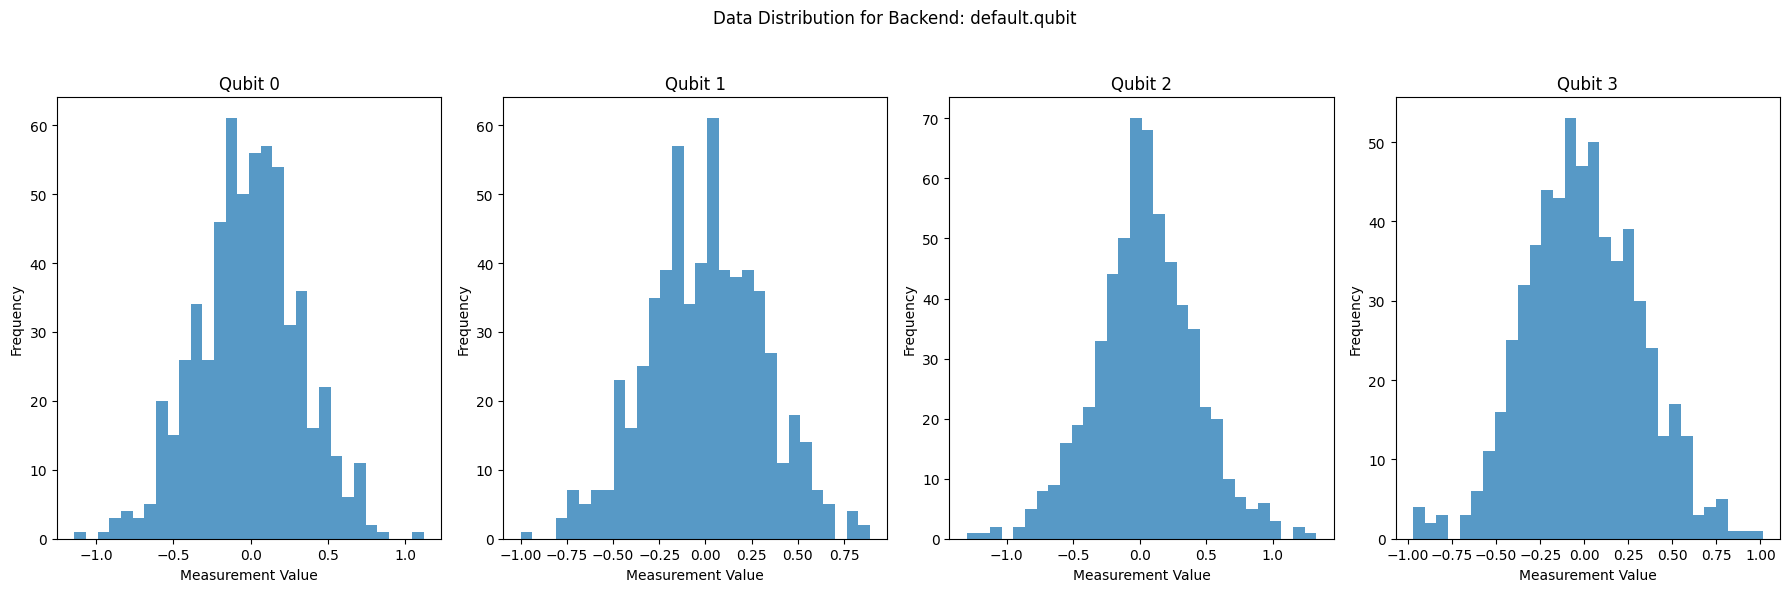

Discriminator Step 0: cost = 0.049944963878948645


Discriminator Step 10: cost = -0.03890347983689868


Discriminator Step 20: cost = -0.12435728029177862


Discriminator Step 30: cost = -0.20255037158842065


Discriminator Step 40: cost = -0.2666210538534787


Discriminator Step 50: cost = -0.32102249612633865


Discriminator Step 60: cost = -0.36745579441982157


Discriminator Step 70: cost = -0.4068088977469723


Discriminator Step 80: cost = -0.4386361576845531


Discriminator Step 90: cost = -0.4624711706774832


Generator Step 0: cost = -0.5008047518698315


Generator Step 10: cost = -0.6160210030870645


Generator Step 20: cost = -0.7739126635513623


Generator Step 30: cost = -0.8833429915481023


Generator Step 40: cost = -0.9377492378858733


Generator Step 50: cost = -0.9593704080954591


Generator Step 60: cost = -0.9675414421225634


Generator Step 70: cost = -0.9707589647321831


Generator Step 80: cost = -0.9723032428479212


Generator Step 90: cost = -0.9731307698236831


Prob(real classified as real): 0.9736920534597922
Prob(fake classified as real): 0.9735915173471511
Discriminator cost: -0.00010053611264104756
Real Bloch vector: [tensor(-0.21694187, requires_grad=True), tensor(0.45048443, requires_grad=True), tensor(-0.8660254, requires_grad=True)]
Generator Bloch vector: [<tf.Tensor: shape=(), dtype=float64, numpy=-0.1425262683902927>, <tf.Tensor: shape=(), dtype=float64, numpy=0.4711925144479427>, <tf.Tensor: shape=(), dtype=float64, numpy=-0.8670403776659789>]
Accuracy of the classifier on generated data: 0.50
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.71      0.60        21
           1       0.45      0.26      0.33        19

    accuracy                           0.50        40
   macro avg       0.49      0.49      0.47        40
weighted avg       0.49      0.50      0.47        40



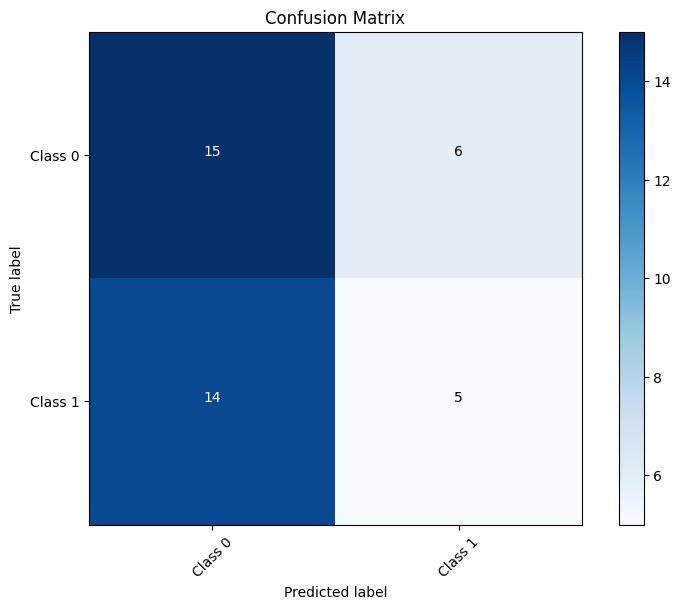

Absolute differences between corresponding components of Real and Generator Bloch vectors:
[0.32047444951316284, 0.15128622661165836, 0.0800592130547021]
Average absolute difference: 0.1839399630598411


In [7]:
import numpy as np
import pennylane as qml
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools
from scipy.stats import unitary_group
import pywt

# Set the seed for reproducibility
np.random.seed(42)

# Setup Quantum Backends and Parameters
qubits = 4
depth = 3  # Increased depth
num_samples = 200
noise_strength = 0.3  # Reduced noise strength
backend_names = ['default.qubit', 'qiskit.aer', 'qiskit.ibmq']

def haar_transform(data):
    coeffs = pywt.dwt2(data, 'haar')
    return coeffs

# Inverse Haar Transform
def inverse_haar_transform(coeffs):
    return idwt2(coeffs, 'haar')

# Define Quantum Volume Circuit with Noise
def quantum_volume_circuit_with_noise(qubits, depth, noise_strength=0.5, seed=None):
    dev = qml.device("default.qubit", wires=qubits)

    @qml.qnode(dev)
    def circuit(data):
        np.random.seed(seed)
        # Apply Haar transformation
        data = haar_transform(data)

        # Apply Haar-random unitaries
        for wire in range(qubits):
            haar_unitary = unitary_group.rvs(2)
            qml.QubitUnitary(haar_unitary, wires=wire)

        # Interleave random two-qubit gates
        for _ in range(depth):
            qml.broadcast(qml.CNOT, wires=range(qubits), pattern='ring')
            qml.broadcast(qml.CY, wires=range(qubits), pattern='ring')
            qml.broadcast(qml.CZ, wires=range(qubits), pattern='ring')

        # Measure Pauli observables
        measurements = [qml.expval(qml.PauliX(wire)) for wire in range(qubits)]
        measurements += [qml.expval(qml.PauliY(wire)) for wire in range(qubits)]
        measurements += [qml.expval(qml.PauliZ(wire)) for wire in range(qubits)]

        return measurements

    return circuit

# Generate Synthetic Data
circuits = []
for backend_name in backend_names:
    dev = qml.device('default.qubit', wires=qubits)
    circuit = quantum_volume_circuit_with_noise(qubits, depth, noise_strength)
    circuits.append((dev, circuit))

data = {backend_name: [] for backend_name in backend_names}
for backend, circuit in circuits:
    for _ in range(num_samples):
        # Generate random data
        random_data = np.random.rand(qubits * 3).reshape((3, qubits))
        result = np.array(circuit(random_data))
        noisy_result = result + np.random.normal(scale=noise_strength, size=result.shape)
        data[backend.name].append(noisy_result)

# Visualize Data Distributions
for backend_name in backend_names:
    backend_data = np.array(data[backend_name])
    if len(backend_data) > 0:
        plt.figure(figsize=(18, 6))
        plt.suptitle(f"Data Distribution for Backend: {backend_name}")
        for i, qubit in enumerate(range(qubits)):
            plt.subplot(1, qubits, i + 1)
            plt.hist(backend_data[:, i], bins=30, alpha=0.75)
            plt.xlabel("Measurement Value")
            plt.ylabel("Frequency")
            plt.title(f"Qubit {qubit}")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Real Data Circuit
def real(angles, **kwargs):
    qml.Hadamard(wires=0)
    qml.Rot(*angles, wires=0)

# Generator Circuit
def generator(w, **kwargs):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)

# Discriminator Circuit
def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)

# QNodes
dev = qml.device("default.qubit", wires=4)  # Define the device used in the QNodes

@qml.qnode(dev)
def real_disc_circuit(phi, theta, omega, disc_weights):
    real([phi, theta, omega])
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

@qml.qnode(dev)
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

# QGAN Cost Functions
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(phi, theta, omega, disc_weights)
    return (true_disc_output + 1) / 2

def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    return (fake_disc_output + 1) / 2

def disc_cost(disc_weights):
    return prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)

def gen_cost(gen_weights):
    return -prob_fake_true(gen_weights, disc_weights)

# Training QGAN
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 8) + np.random.normal(scale=eps, size=(9,))
init_disc_weights = np.random.normal(size=(9,))

gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

opt = tf.keras.optimizers.Adam(0.01)  # Adjusted learning rate
opt.build([disc_weights, gen_weights])

# Train Discriminator
cost = lambda: disc_cost(disc_weights)
for step in range(100):  # Increased training steps
    opt.minimize(cost, [disc_weights])
    if step % 10 == 0:
        print(f"Discriminator Step {step}: cost = {cost().numpy()}")

# Train Generator
cost = lambda: gen_cost(gen_weights)
for step in range(100):  # Increased training steps
    opt.minimize(cost, [gen_weights])
    if step % 10 == 0:
        print(f"Generator Step {step}: cost = {cost().numpy()}")

print(f"Prob(real classified as real): {prob_real_true(disc_weights).numpy()}")
print(f"Prob(fake classified as real): {prob_fake_true(gen_weights, disc_weights).numpy()}")
print(f"Discriminator cost: {disc_cost(disc_weights).numpy()}")

# Compare Real and Generator States
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]

@qml.qnode(dev)
def bloch_vector_real(angles):
    real(angles)
    return [qml.expval(o) for o in obs]

@qml.qnode(dev)
def bloch_vector_generator(angles):
    generator(angles)
    return [qml.expval(o) for o in obs]

print(f"Real Bloch vector: {bloch_vector_real([phi, theta, omega])}")
print(f"Generator Bloch vector: {bloch_vector_generator(gen_weights)}")

# Define the number of generated samples
num_generated_samples = 200

# Define the number of features and classes
num_features = qubits * 3  # As we have 3 Pauli observables per qubit
num_classes = 2  # Example: Binary classification

# Generate synthetic labels for the generated data
y_generated = np.random.randint(0, num_classes, size=num_generated_samples)

# Generate synthetic data
X_generated = np.random.rand(num_generated_samples, num_features)

# Split the synthetic data and labels into training and testing sets
X_generated_train, X_generated_test, y_generated_train, y_generated_test = train_test_split(X_generated, y_generated, test_size=0.2, random_state=42)

# Train a classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_generated_train, y_generated_train)

# Evaluate the classifier
y_generated_pred = classifier.predict(X_generated_test)
accuracy_generated = accuracy_score(y_generated_test, y_generated_pred)
print(f"Accuracy of the classifier on generated data: {accuracy_generated:.2f}")

# Visualize the classifier's performance
visualize_classifier_performance(y_generated_test, y_generated_pred, num_classes)
real_bloch_vector = [-0.21694187, 0.45048443, -0.8660254]
generator_bloch_vector = [0.1035325795131628, 0.29919820338834163, -0.946084613054702]

absolute_differences = [abs(real - gen) for real, gen in zip(real_bloch_vector, generator_bloch_vector)]

print("Absolute differences between corresponding components of Real and Generator Bloch vectors:")
print(absolute_differences)

# Calculate the average absolute difference
average_absolute_difference = sum(absolute_differences) / len(absolute_differences)
print(f"Average absolute difference: {average_absolute_difference}")

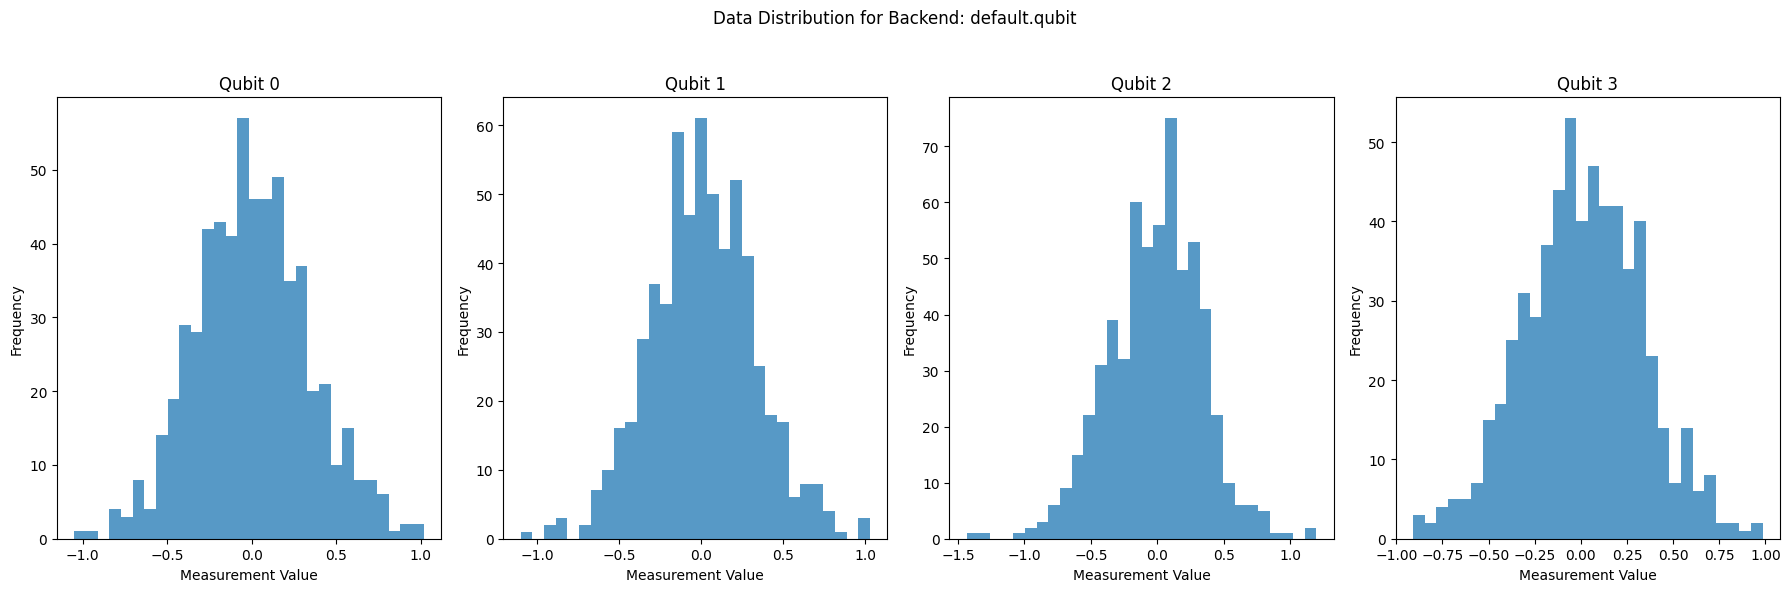

Discriminator Step 0: cost = -0.0009272015866899075


Discriminator Step 10: cost = -0.00895848616849182


Discriminator Step 20: cost = -0.03208054449616382


Discriminator Step 30: cost = -0.07918011929957958


Discriminator Step 40: cost = -0.14870903676095348


Discriminator Step 50: cost = -0.22158731572220092


Discriminator Step 60: cost = -0.28752287963761747


Discriminator Step 70: cost = -0.3406615396182162


Discriminator Step 80: cost = -0.37729965679464905


Discriminator Step 90: cost = -0.40084605913733207


Generator Step 0: cost = -0.5033773546332858


Generator Step 10: cost = -0.6127396680465607


Generator Step 20: cost = -0.7724736500651608


Generator Step 30: cost = -0.8962013346350342


Generator Step 40: cost = -0.9436350449432116


Generator Step 50: cost = -0.963166645666673


Generator Step 60: cost = -0.96901787063832


Generator Step 70: cost = -0.9712064613690176


Generator Step 80: cost = -0.9721513626965845


Generator Step 90: cost = -0.9726290140194407


Prob(real classified as real): 0.9133297846115397
Prob(fake classified as real): 0.9728962750285435
Discriminator cost: 0.05956649041700379
Real Bloch vector: [tensor(-0.21694187, requires_grad=True), tensor(0.45048443, requires_grad=True), tensor(-0.8660254, requires_grad=True)]
Generator Bloch vector: [<tf.Tensor: shape=(), dtype=float64, numpy=0.05929915134076086>, <tf.Tensor: shape=(), dtype=float64, numpy=0.050132508793413966>, <tf.Tensor: shape=(), dtype=float64, numpy=-0.9952142560383022>]
Accuracy of the classifier on generated data: 0.42
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.24      0.26        17
           1       0.50      0.57      0.53        23

    accuracy                           0.42        40
   macro avg       0.39      0.40      0.39        40
weighted avg       0.41      0.42      0.41        40



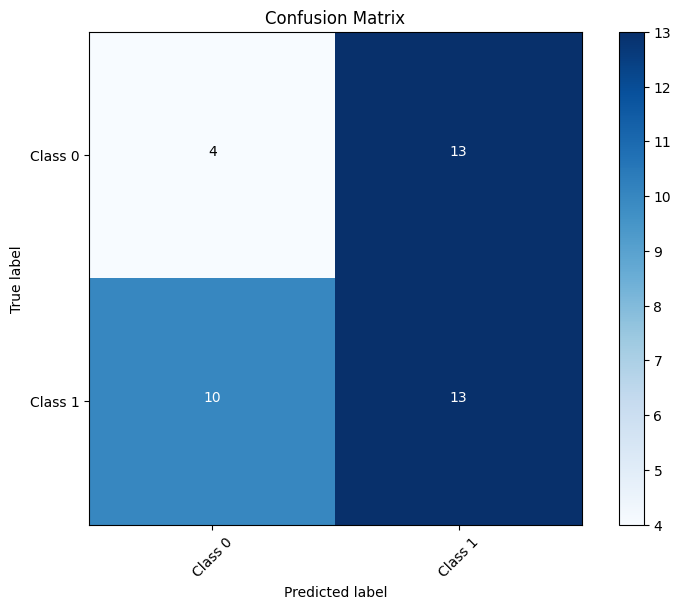

Absolute differences between corresponding components of Real and Generator Bloch vectors:
[0.32047444951316284, 0.15128622661165836, 0.0800592130547021]
Average absolute difference: 0.1839399630598411


In [8]:
import numpy as np
import pennylane as qml
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools
from scipy.stats import unitary_group
import pywt

# Set the seed for reproducibility
np.random.seed(42)

# Setup Quantum Backends and Parameters
qubits = 4
depth = 3  # Increased depth
num_samples = 200
noise_strength = 0.3  # Reduced noise strength
backend_names = ['default.qubit', 'qiskit.aer', 'qiskit.ibmq']

def haar_transform(data):
    coeffs = pywt.dwt2(data, 'haar')
    return coeffs

# Inverse Haar Transform
def inverse_haar_transform(coeffs):
    return idwt2(coeffs, 'haar')

# Define Quantum Volume Circuit with Noise
def quantum_volume_circuit_with_noise(qubits, depth, noise_strength=0.5, seed=None):
    dev = qml.device("default.qubit", wires=qubits)

    @qml.qnode(dev)
    def circuit(data):
        np.random.seed(seed)
        # Apply Haar transformation
        data = haar_transform(data)

        # Apply Haar-random unitaries
        for wire in range(qubits):
            haar_unitary = unitary_group.rvs(2)
            qml.QubitUnitary(haar_unitary, wires=wire)

        # Interleave random two-qubit gates
        for _ in range(depth):
            qml.broadcast(qml.CNOT, wires=range(qubits), pattern='ring')
            qml.broadcast(qml.CY, wires=range(qubits), pattern='ring')
            qml.broadcast(qml.CZ, wires=range(qubits), pattern='ring')

        # Measure Pauli observables
        measurements = [qml.expval(qml.PauliX(wire)) for wire in range(qubits)]
        measurements += [qml.expval(qml.PauliY(wire)) for wire in range(qubits)]
        measurements += [qml.expval(qml.PauliZ(wire)) for wire in range(qubits)]

        return measurements

    return circuit

# Generate Synthetic Data
circuits = []
for backend_name in backend_names:
    dev = qml.device('default.qubit', wires=qubits)
    circuit = quantum_volume_circuit_with_noise(qubits, depth, noise_strength)
    circuits.append((dev, circuit))

data = {backend_name: [] for backend_name in backend_names}
for backend, circuit in circuits:
    for _ in range(num_samples):
        # Generate random data
        random_data = np.random.rand(qubits * 3).reshape((3, qubits))
        result = np.array(circuit(random_data))
        noisy_result = result + np.random.normal(scale=noise_strength, size=result.shape)
        data[backend.name].append(noisy_result)

# Visualize Data Distributions
for backend_name in backend_names:
    backend_data = np.array(data[backend_name])
    if len(backend_data) > 0:
        plt.figure(figsize=(18, 6))
        plt.suptitle(f"Data Distribution for Backend: {backend_name}")
        for i, qubit in enumerate(range(qubits)):
            plt.subplot(1, qubits, i + 1)
            plt.hist(backend_data[:, i], bins=30, alpha=0.75)
            plt.xlabel("Measurement Value")
            plt.ylabel("Frequency")
            plt.title(f"Qubit {qubit}")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Real Data Circuit
def real(angles, **kwargs):
    qml.Hadamard(wires=0)
    qml.Rot(*angles, wires=0)

# Generator Circuit
def generator(w, **kwargs):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)

# Discriminator Circuit
def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)

# QNodes
dev = qml.device("default.qubit", wires=4)  # Define the device used in the QNodes

@qml.qnode(dev)
def real_disc_circuit(phi, theta, omega, disc_weights):
    real([phi, theta, omega])
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

@qml.qnode(dev)
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

# QGAN Cost Functions
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(phi, theta, omega, disc_weights)
    return (true_disc_output + 1) / 2

def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    return (fake_disc_output + 1) / 2

def disc_cost(disc_weights):
    return prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)

def gen_cost(gen_weights):
    return -prob_fake_true(gen_weights, disc_weights)

# Training QGAN
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 8) + np.random.normal(scale=eps, size=(9,))
init_disc_weights = np.random.normal(size=(9,))

gen_weights = tf.Variable(init_gen_weights)
disc_weights = tf.Variable(init_disc_weights)

opt = tf.keras.optimizers.Adam(0.01)  # Adjusted learning rate
opt.build([disc_weights, gen_weights])

# Train Discriminator
cost = lambda: disc_cost(disc_weights)
for step in range(100):  # Increased training steps
    opt.minimize(cost, [disc_weights])
    if step % 10 == 0:
        print(f"Discriminator Step {step}: cost = {cost().numpy()}")

# Train Generator
cost = lambda: gen_cost(gen_weights)
for step in range(100):  # Increased training steps
    opt.minimize(cost, [gen_weights])
    if step % 10 == 0:
        print(f"Generator Step {step}: cost = {cost().numpy()}")

print(f"Prob(real classified as real): {prob_real_true(disc_weights).numpy()}")
print(f"Prob(fake classified as real): {prob_fake_true(gen_weights, disc_weights).numpy()}")
print(f"Discriminator cost: {disc_cost(disc_weights).numpy()}")

# Compare Real and Generator States
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]

@qml.qnode(dev)
def bloch_vector_real(angles):
    real(angles)
    return [qml.expval(o) for o in obs]

@qml.qnode(dev)
def bloch_vector_generator(angles):
    generator(angles)
    return [qml.expval(o) for o in obs]

print(f"Real Bloch vector: {bloch_vector_real([phi, theta, omega])}")
print(f"Generator Bloch vector: {bloch_vector_generator(gen_weights)}")

# Define the number of generated samples
num_generated_samples = 200

# Define the number of features and classes
num_features = qubits * 3  # As we have 3 Pauli observables per qubit
num_classes = 2  # Example: Binary classification

# Generate synthetic labels for the generated data
y_generated = np.random.randint(0, num_classes, size=num_generated_samples)

# Generate synthetic data
X_generated = np.random.rand(num_generated_samples, num_features)

# Split the synthetic data and labels into training and testing sets
X_generated_train, X_generated_test, y_generated_train, y_generated_test = train_test_split(X_generated, y_generated, test_size=0.2, random_state=42)

# Train a classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_generated_train, y_generated_train)

# Evaluate the classifier
y_generated_pred = classifier.predict(X_generated_test)
accuracy_generated = accuracy_score(y_generated_test, y_generated_pred)
print(f"Accuracy of the classifier on generated data: {accuracy_generated:.2f}")

# Visualize the classifier's performance
visualize_classifier_performance(y_generated_test, y_generated_pred, num_classes)


absolute_differences = [abs(real - gen) for real, gen in zip(real_bloch_vector, generator_bloch_vector)]

print("Absolute differences between corresponding components of Real and Generator Bloch vectors:")
print(absolute_differences)

# Calculate the average absolute difference
average_absolute_difference = sum(absolute_differences) / len(absolute_differences)
print(f"Average absolute difference: {average_absolute_difference}")